In [1]:
import os
import math, datetime, itertools
import pandas as pd
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

sns.set_theme(style='whitegrid')
sns.set_palette("Paired")

In [2]:
pal = sns.husl_palette(20, h=.6)

# Read all data

In [3]:
data_folder = '../CoverMyMeds_data/'
def path_for(filename, folder=data_folder):
    return os.path.join(folder, filename)

df_date = pd.read_csv(path_for('dim_date.csv'))
df_pa = pd.read_csv(path_for('dim_pa.csv'))
df_bridge = pd.read_csv(path_for('bridge.csv'))

In [4]:
df_date.head(3)

,dim_date_id,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,2017-01-01,2017,1,1,1,0,0,1
1,2,2017-01-02,2017,1,2,2,1,0,0
2,3,2017-01-03,2017,1,3,3,1,1,0


In [5]:
df_pa.head(3)

,dim_pa_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,1,1,0,1
1,2,1,0,0,1
2,3,0,0,1,1


In [6]:
df_bridge[df_bridge['dim_pa_id'] > 0].head(10)

,dim_claim_id,dim_pa_id,dim_date_id
0,1,1.0,1
2,3,2.0,1
9,10,3.0,1
10,11,4.0,1
14,15,5.0,1
15,16,6.0,1
17,18,7.0,1
19,20,8.0,1
20,21,9.0,1
21,22,10.0,1


# Merge dataframes

In [7]:
df = pd.merge(df_pa, df_bridge, on = 'dim_pa_id')

In [8]:
df.head(3)

,dim_pa_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,dim_claim_id,dim_date_id
0,1,1,1,0,1,1,1
1,2,1,0,0,1,3,1
2,3,0,0,1,1,10,1


In [9]:
df = df.merge(df_date, on = 'dim_date_id')

In [10]:
df.head(3)

,dim_pa_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,dim_claim_id,dim_date_id,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,1,1,0,1,1,1,2017-01-01,2017,1,1,1,0,0,1
1,2,1,0,0,1,3,1,2017-01-01,2017,1,1,1,0,0,1
2,3,0,0,1,1,10,1,2017-01-01,2017,1,1,1,0,0,1


In [11]:
df.columns

Index(['dim_pa_id', 'correct_diagnosis', 'tried_and_failed',
       'contraindication', 'pa_approved', 'dim_claim_id', 'dim_date_id',
       'date_val', 'calendar_year', 'calendar_month', 'calendar_day',
       'day_of_week', 'is_weekday', 'is_workday', 'is_holiday'],
      dtype='object')

In [12]:
df = df.drop(['dim_pa_id', 'correct_diagnosis', 'tried_and_failed',
       'contraindication', 'pa_approved', 'dim_claim_id', 'dim_date_id'], axis = 1)

In [13]:
df.columns

Index(['date_val', 'calendar_year', 'calendar_month', 'calendar_day',
       'day_of_week', 'is_weekday', 'is_workday', 'is_holiday'],
      dtype='object')

# PA volume prediction

## Plots of weekly data

In [14]:
# Add calendar week
df['calendar_week'] = df.apply(lambda row: datetime.date(row['calendar_year'], row['calendar_month'], row['calendar_day']).isocalendar()[1], axis=1)

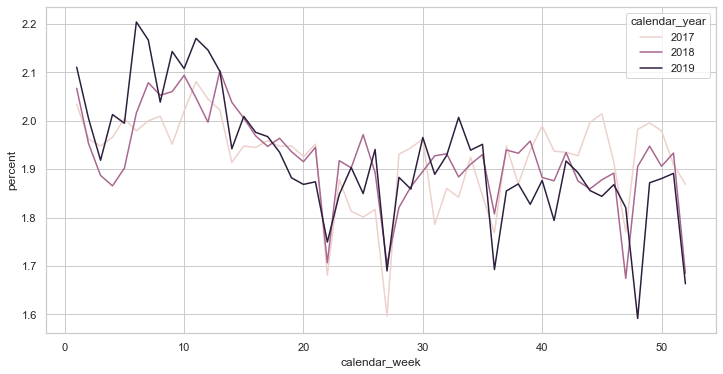

In [15]:
# Plot PA by week
fig, ax = plt.subplots(figsize=(12, 6))

df_weekly = df.groupby('calendar_year')['calendar_week'].value_counts(normalize=True)
df_weekly = df_weekly.mul(100)
df_weekly = df_weekly.rename('percent').reset_index()

lp = sns.lineplot(x = 'calendar_week', y = 'percent', hue='calendar_year', data= df_weekly, ax = ax)

In [16]:
df = df.drop(['calendar_week'], axis = 1)

## More prep

In [17]:
# Save this for later.
vol_2017 = df[df['calendar_year'] == 2017].groupby('calendar_year')['date_val'].value_counts().sum()
vol_2018 = df[df['calendar_year'] == 2018].groupby('calendar_year')['date_val'].value_counts().sum()
vol_2019 = df[df['calendar_year'] == 2019].groupby('calendar_year')['date_val'].value_counts().sum()

vol_dict = dict([(2017, vol_2017), (2018, vol_2018), (2019, vol_2019)])
df_vol = pd.DataFrame([[2017, vol_2017], [2018, vol_2018], [2019, vol_2019]], columns = ['calendar_year', 'volume'])

In [18]:
vol_dict

{2017: 159438, 2018: 190011, 2019: 206502}

In [19]:
df_vol = pd.DataFrame(data = df.groupby('date_val')['date_val'].count().rename('daily_vol')).reset_index()
df_vol

,date_val,daily_vol
0,2017-01-01,94
1,2017-01-02,437
2,2017-01-03,614
3,2017-01-04,591
4,2017-01-05,598
...,...,...
1090,2019-12-27,682
1091,2019-12-28,262
1092,2019-12-29,207
1093,2019-12-30,596


In [20]:
df_per = df.groupby('calendar_year')['date_val'].value_counts(normalize=True).mul(100).rename('daily_per').reset_index()
df_per

,calendar_year,date_val,daily_per
0,2017,2017-11-28,0.396392
1,2017,2017-03-23,0.393256
2,2017,2017-05-11,0.388866
3,2017,2017-12-06,0.386357
4,2017,2017-01-03,0.385103
...,...,...,...
1090,2019,2019-12-08,0.102662
1091,2019,2019-06-08,0.101694
1092,2019,2019-12-29,0.100241
1093,2019,2019-09-22,0.097820


In [21]:
df = df.drop_duplicates()
df = df.merge(df_vol, how = 'left', on = 'date_val')
df = df.merge(df_per[['date_val', 'daily_per']], how = 'left', on = 'date_val')

In [22]:
df.corr()['daily_vol'].sort_values()

is_holiday       -0.161851
calendar_month   -0.073604
calendar_day      0.003542
day_of_week       0.037934
calendar_year     0.260435
is_weekday        0.911305
is_workday        0.931678
daily_per         0.959167
daily_vol         1.000000
Name: daily_vol, dtype: float64

## Useful definitions

In [23]:
def error(actual, prediction):
    return abs(prediction - actual)

def mae(actual, prediction, rounding = 5):
    errors = error(actual, prediction)
    return round(np.mean(errors), rounding)

def accuracy(actual, prediction, rounding = 5):
    errors = error(actual, prediction)
    return 100 - 100 * np.mean((errors / actual))

def rmse(actual, prediction, rounding = 5):
    errors = error(actual, prediction)
    return round(mean_squared_error(actual, prediction, squared = False), rounding)

def measure(actual, prediction, rounding = 5):
    return (mae(actual, prediction, rounding), accuracy(actual, prediction, rounding), rmse(actual, prediction, rounding))

# Random forest regressor
The approach in this section was inspired by the approach in the following article: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0. 

In [24]:
class RegressionData():
  def __init__(self, train_df, test_df, features, labels):
    
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    self.train_labels = np.array(train_df[labels]).ravel()
    self.train_features = np.array(train_df[features])
    self.test_labels = np.array(test_df[labels]).ravel()
    self.test_features = np.array(test_df[features])
      
    self.features = features
    self.labels = labels
    
  def fit(self, regressor):
    regressor.fit(self.train_features, self.train_labels)

  def predict(self, regressor):
    return regressor.predict(self.test_features)

  def get_actual(self):
    return self.test_labels

  def __repr__(self):
    return '\n'.join([
        f'Features : {self.features}',
        f'Labels: {self.labels}',
        f'Train set size: {self.train_labels.shape[0]}',
        f'Test set size: {self.test_labels.shape[0]}'])

In [25]:
# This is the dataset that will be used for the following regressions.
rf_data = RegressionData(df[df['calendar_year'] < 2019], df[df['calendar_year'] == 2019], 
                        ['calendar_month', 'calendar_day', 'day_of_week', 'is_weekday', 'is_workday', 'is_holiday'],
                        ['daily_per'])
print(rf_data)

Features : ['calendar_month', 'calendar_day', 'day_of_week', 'is_weekday', 'is_workday', 'is_holiday']
Labels: ['daily_per']
Train set size: 730
Test set size: 365


In [26]:
actual = rf_data.get_actual()
actual = actual*vol_dict[2019]*0.01

In [27]:
# Regressor to be used
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [28]:
# Fit.
rf_data.fit(rf)

In [29]:
# Predict.
predictions = rf_data.predict(rf)*vol_dict[2019]*0.01;

In [30]:
# Check the prediction.

# Calculate the mean absolute errors (MAE)
print('Mean Absolute Error:', mae(actual, predictions))

# Calculate the mean absolute percentage error (MAPE)
print('Accuracy:', accuracy(actual, predictions), '%.')

# Calculate the root mean squared error (RMSE)
print('Mean Squared Error:', rmse(actual, predictions))

Mean Absolute Error: 28.33868
Accuracy: 94.74212322739032 %.
Mean Squared Error: 37.77913


In [31]:
# Label importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(rf_data.features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: is_workday           Importance: 0.94
Variable: day_of_week          Importance: 0.02
Variable: calendar_month       Importance: 0.01
Variable: calendar_day         Importance: 0.01
Variable: is_weekday           Importance: 0.01
Variable: is_holiday           Importance: 0.01


In [32]:
# Permutation feature importance
r = permutation_importance(rf, rf_data.test_features, rf_data.test_labels, n_repeats = 30, random_state = 42)

for i in r.importances_mean.argsort()[::-1]:
    print(f"{rf_data.features[i]:<8}"
          f" {r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

is_workday 0.887 +/- 0.049
is_weekday 0.500 +/- 0.028
is_holiday 0.029 +/- 0.001
day_of_week 0.028 +/- 0.004
calendar_month 0.015 +/- 0.002
calendar_day 0.003 +/- 0.001


In [33]:
n_repeats = 50

preds = []
maes = []
accs = []
rmses = []

data = rf_data
for repeats in range(n_repeats):   
    
    data.fit(rf)
    prediction = data.predict(rf);
    prediction = prediction*vol_dict[2019]*0.01
    
    preds.append(prediction.reshape(-1))
    measures = measure(actual, prediction)
    maes.append(measures[0])
    accs.append(measures[1])
    rmses.append(measures[2])
    
preds = np.array(preds)
maes = np.array(maes)
accs = np.array(accs)
rmses = np.array(rmses)

# Print measures.
print('MAE averaged over ', n_repeats, 'reps : ', np.mean(maes))
print('Accuracy averaged over ', n_repeats, 'reps : ', np.mean(accs))
print('RMSE averaged over ', n_repeats, 'reps : ', np.mean(rmses))

# Assume normal distribution.
mean = np.mean(preds, axis=0).reshape(-1)
std = np.std(preds, axis=0).reshape(-1)
lower = np.percentile(preds, 5, axis=0).reshape(-1)
upper = np.percentile(preds, 95, axis=0).reshape(-1)

# Print std.
print(f'Max and Mean standard deviation are: {np.amax(std)} and {np.mean(std)}')

MAE averaged over  50 reps :  28.338680000000004
Accuracy averaged over  50 reps :  94.74212322739031
RMSE averaged over  50 reps :  37.77913
Max and Mean standard deviation are: 1.0231815394945443e-12 and 3.166879239820633e-13


## Random forest without calendar_day
Pemutation importance suggest 'calendar_day' might be of very little importance. Try omitting it and see if prediction improves. A minute improvement will be observed and data with 'calendar_day' omitted will be used after this section unless specifically noted otherwise.

In [34]:
rf_data_no_day = RegressionData(df[df['calendar_year'] < 2019], df[df['calendar_year'] == 2019], 
                        ['calendar_month', 'day_of_week', 'is_weekday', 'is_workday', 'is_holiday'],
                        ['daily_per'])
print(rf_data)

Features : ['calendar_month', 'calendar_day', 'day_of_week', 'is_weekday', 'is_workday', 'is_holiday']
Labels: ['daily_per']
Train set size: 730
Test set size: 365


In [35]:
n_repeats = 50

preds = []
maes = []
accs = []
rmses = []

data = rf_data_no_day
for repeats in range(n_repeats):   
    
    data.fit(rf)
    prediction = data.predict(rf);
    prediction = prediction*vol_dict[2019]*0.01
    
    preds.append(prediction.reshape(-1))
    measures = measure(actual, prediction)
    maes.append(measures[0])
    accs.append(measures[1])
    rmses.append(measures[2])
    
preds = np.array(preds)
maes = np.array(maes)
accs = np.array(accs)
rmses = np.array(rmses)

# Print measures.
print('MAE averaged over ', n_repeats, 'reps : ', np.mean(maes))
print('Accuracy averaged over ', n_repeats, 'reps : ', np.mean(accs))
print('RMSE averaged over ', n_repeats, 'reps : ', np.mean(rmses))

# Assume normal distribution.
mean = np.mean(preds, axis=0).reshape(-1)
std = np.std(preds, axis=0).reshape(-1)
lower = np.percentile(preds, 5, axis=0).reshape(-1)
upper = np.percentile(preds, 95, axis=0).reshape(-1)

# Print std.
print(f'Max and Mean standard deviation are: {np.amax(std)} and {np.mean(std)}')

MAE averaged over  50 reps :  27.90612
Accuracy averaged over  50 reps :  94.74846738347179
RMSE averaged over  50 reps :  36.70955000000001
Max and Mean standard deviation are: 1.0231815394945443e-12 and 2.9184812861686085e-13


## Prediction Intervals
The codes and the approach here are adopted form the following blog post: https://medium.com/dataman-in-ai/a-tutorial-on-quantile-regression-quantile-random-forests-and-quantile-gbm-d3c651af7516.

In [36]:
rf_q = RandomForestRegressor(n_estimators=200, random_state=0,min_samples_split=10)
rf_data_no_day.fit(rf_q)

In [37]:
upper, lower = 0.95, 0.05

In [38]:
# Get the predictions of all trees for all observations
# Each observation has N predictions from the N trees
pred_q = pd.DataFrame()

# Get the predictions of all trees for all observations
# Each observation has N predictions from the N trees
for estimator in rf.estimators_:
    temp = pd.Series(rf_data_no_day.predict(estimator)*vol_dict[2019]*0.01)
    pred_q = pd.concat([pred_q, temp], axis = 1)


In [39]:
pred_q

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,282.350732,282.350732,270.610638,286.717936,270.610638,270.610638,282.350732,270.610638,270.610638,270.610638,...,270.610638,288.826666,280.391746,282.500476,270.610638,288.826666,270.610638,280.391746,270.610638,270.610638
1,714.815695,719.930753,695.921340,731.345427,741.202288,727.673078,715.101279,710.803011,726.736769,742.036971,...,713.710330,718.687924,737.266592,728.389305,712.906714,714.633154,731.426625,686.940336,705.821129,715.047627
2,733.098830,746.683180,724.269883,760.922271,740.170227,734.611543,720.908106,741.388887,721.694481,734.793542,...,724.346726,754.245587,736.716963,744.284765,700.845244,723.492923,715.291594,746.446192,729.330568,727.536701
3,705.924296,683.233374,701.144804,717.448001,682.191410,690.565424,691.510767,677.432254,688.080214,701.776562,...,700.729507,678.839001,720.029599,702.771156,679.326064,726.238498,698.584299,716.789271,690.558108,715.590731
4,247.710197,245.387357,251.444237,239.221920,244.439514,253.691392,249.645940,251.036158,246.010663,246.497904,...,247.587199,240.712569,247.677368,244.273463,237.431157,252.587720,251.826298,249.539332,230.399419,242.314080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,682.712381,668.055203,675.242531,682.118016,670.804952,682.191298,687.607116,677.914353,670.327716,675.287481,...,683.032338,680.196420,684.733559,679.630713,685.384745,676.176882,674.923721,686.445399,675.060243,674.801640
361,242.173857,232.232743,239.717276,241.195979,237.653228,234.292934,245.703589,237.856488,242.081021,239.836178,...,236.895312,237.969116,234.682708,236.634677,242.961867,240.371442,236.589956,237.839610,240.070615,234.644489
362,243.127978,244.448097,241.858445,249.376944,244.047441,240.515080,240.079695,242.471750,250.705744,239.963285,...,242.203117,241.802513,238.987817,251.956805,247.668163,243.218348,248.819884,243.422800,243.531731,236.797208
363,652.703687,650.935230,656.451094,655.331538,650.111248,657.610642,653.680377,651.052073,652.624943,660.789953,...,661.800563,650.942933,646.208538,657.913661,657.314585,656.418771,649.081833,649.848440,664.293870,650.521159


In [40]:
rf_actual_pred = pd.DataFrame()

for q in [upper, lower]:
    s = pred_q.quantile(q = q, axis = 1)
    rf_actual_pred = pd.concat([rf_actual_pred, s], axis = 1, sort = False)


In [41]:
rf_actual_pred

,0.95,0.05
0,288.826666,270.610638
1,740.592954,699.167155
2,754.566314,717.429033
3,723.087269,672.281924
4,253.809286,236.751344
...,...,...
360,691.784264,667.287447
361,243.791330,231.771519
362,251.520433,236.479342
363,665.910100,642.690249


In [42]:
rf_actual_pred['pred'] =  rf_data_no_day.predict(rf_q)*vol_dict[2019]*0.01
rf_actual_pred['actual'] = actual
rf_actual_pred['interval'] = rf_actual_pred[upper] - rf_actual_pred[lower]
rf_actual_pred

,0.95,0.05,pred,actual,interval
0,288.826666,270.610638,328.082633,341.0,18.216028
1,740.592954,699.167155,719.990930,735.0,41.425799
2,754.566314,717.429033,734.380921,748.0,37.137281
3,723.087269,672.281924,698.449288,744.0,50.805345
4,253.809286,236.751344,247.842905,244.0,17.057942
...,...,...,...,...,...
360,691.784264,667.287447,679.719543,682.0,24.496817
361,243.791330,231.771519,237.763612,262.0,12.019811
362,251.520433,236.479342,244.303371,207.0,15.041091
363,665.910100,642.690249,653.937514,596.0,23.219851


In [43]:
rf_actual_pred[(rf_actual_pred[0.95] <= rf_actual_pred['pred']) | (rf_actual_pred['pred'] <= rf_actual_pred[0.05]) ]

,0.95,0.05,pred,actual,interval
0,288.826666,270.610638,328.082633,341.0,18.216028
146,288.826666,270.610638,328.082633,241.0,18.216028
184,304.902038,282.350732,328.082633,294.0,22.551306
244,296.597787,271.697428,328.197155,290.0,24.900359
331,315.169017,295.606802,328.666143,263.0,19.562215
332,654.069356,577.085337,478.869033,567.0,76.984019
358,315.169017,284.147608,328.666143,344.0,31.021409


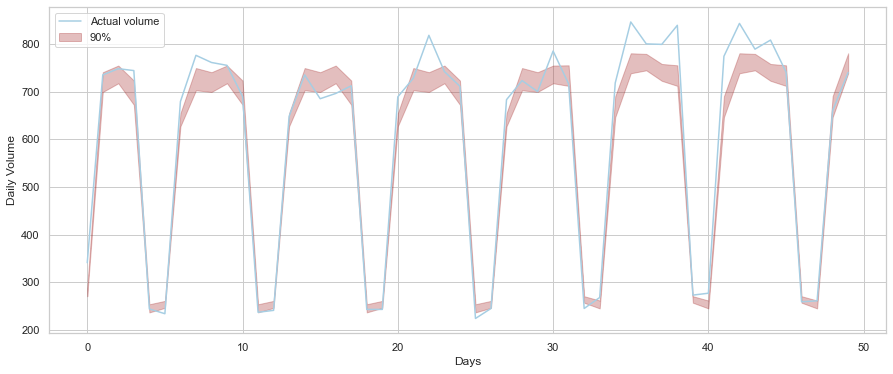

In [44]:
# Plotting with prediction interval.
days = 50

fig, ax = plt.subplots(figsize = (15,6))
ax.plot(rf_actual_pred['actual'][:days], label = 'Actual volume')
ax.fill_between(range(days), rf_actual_pred[0.95][:days], rf_actual_pred[0.05][:days], label='90%', color='brown', alpha=.3)
ax.set(ylabel = "Daily Volume", xlabel="Days")
ax.legend();

# RNN

The codes in this section are heavily based on the codes from following sources:
1. https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
2. https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
3. https://towardsdatascience.com/time-series-in-python-part-3-forecasting-taxi-trips-with-lstms-277afd4f811

In [45]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

np.random.seed(7)

In [46]:
# Convert an array of values into a dataset matrix.
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [47]:
class RNNData():
  def __init__(self, dataset, train_size, look_back = 28): 
    # Store the raw data.
    self.train_size = train_size
    self.test_size = len(dataset) - train_size
    self.look_back = look_back
    
    self.original_dataset = dataset
    dataset = dataset.values.astype('float32')
    dataset = np.reshape(dataset, (-1,1))
    self.scaler = MinMaxScaler(feature_range = (0, 1))
    self.dataset = self.scaler.fit_transform(dataset)
    
    self.train, self.test = self.dataset[0:train_size,:], self.dataset[train_size:len(dataset),:]
    
    trainX, self.trainY = create_dataset(self.train, self.look_back)
    self.trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    
    testX, self.testY = create_dataset(self.test, self.look_back)
    self.testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  def fit_and_predict(self, epochs = 33, dropout = 0, batch_size = 1, verbose = 2):
    model = Sequential()
    model.add(LSTM(100, input_shape = (1, self.look_back)))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    model.fit(self.trainX, self.trainY, epochs = epochs, batch_size = batch_size, verbose = verbose)
    pred = model.predict(self.testX)
    pred = self.invert(pred)
    return pred.T

  def invert(self, data):
    return self.scaler.inverse_transform(data)

  def get_actual(self):
    return self.invert([self.testY.reshape(-1)])

  def __repr__(self):
    return '\n'.join([
        f'Train X shape: {self.trainX.shape}',
        f'Train Y shape: {self.trainY.shape}',
        f'Test X shape: {self.testX.shape}',
        f'Test Y shape: {self.testY.shape}'])

In [48]:
rnn_data = RNNData(df['daily_vol'], 365*2, look_back = 28)
print(rnn_data)

Train X shape: (701, 1, 28)
Train Y shape: (701,)
Test X shape: (336, 1, 28)
Test Y shape: (336,)


In [49]:
prediction = rnn_data.fit_and_predict();

Epoch 1/33
701/701 - 19s - loss: 0.0122
Epoch 2/33
701/701 - 1s - loss: 0.0073
Epoch 3/33
701/701 - 1s - loss: 0.0064
Epoch 4/33
701/701 - 1s - loss: 0.0060
Epoch 5/33
701/701 - 1s - loss: 0.0058
Epoch 6/33
701/701 - 1s - loss: 0.0058
Epoch 7/33
701/701 - 1s - loss: 0.0056
Epoch 8/33
701/701 - 1s - loss: 0.0054
Epoch 9/33
701/701 - 1s - loss: 0.0057
Epoch 10/33
701/701 - 1s - loss: 0.0053
Epoch 11/33
701/701 - 1s - loss: 0.0053
Epoch 12/33
701/701 - 1s - loss: 0.0055
Epoch 13/33
701/701 - 1s - loss: 0.0053
Epoch 14/33
701/701 - 1s - loss: 0.0053
Epoch 15/33
701/701 - 1s - loss: 0.0052
Epoch 16/33
701/701 - 1s - loss: 0.0052
Epoch 17/33
701/701 - 1s - loss: 0.0050
Epoch 18/33
701/701 - 1s - loss: 0.0051
Epoch 19/33
701/701 - 1s - loss: 0.0049
Epoch 20/33
701/701 - 1s - loss: 0.0049
Epoch 21/33
701/701 - 1s - loss: 0.0051
Epoch 22/33
701/701 - 1s - loss: 0.0049
Epoch 23/33
701/701 - 1s - loss: 0.0050
Epoch 24/33
701/701 - 1s - loss: 0.0047
Epoch 25/33
701/701 - 1s - loss: 0.0048
Epoch 26

In [50]:
actual = rnn_data.get_actual()
actual.shape

(1, 336)

In [51]:
# Check the prediction.
errors = abs(prediction - actual)

# Calculate the mean absolute errors (MAE).
print('Mean Absolute Error:', mae(actual, prediction))

# Calculate the mean absolute percentage error (MAPE).
print('Accuracy:', accuracy(actual, prediction), '%.')

# Calculate the root mean squared error (RMSE)
print('Root Mean Squared Error:', rmse(actual, prediction))

Mean Absolute Error: 46.41266
Accuracy: 90.70613583799272 %.
Root Mean Squared Error: 46.41266


## Deciding on parameters
I adopted some ideas from the following article: https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/. Due to time constraint, I will only adjust the number of epoch and the drop out rate.

In [102]:
# Search for a (epoch, dropout) pair using RMSE.
epochs = [10, 20, 30, 40, 50]
dropouts = [0, 0.25, 0.5, 0.75]

configs = itertools.product(epochs, dropouts)

df_config = pd.DataFrame(columns = ['epoch', 'dropout', 'rmse_mean', 'rmse_std'])
n_reps = 10

for config in configs:
    rmses = []
    epoch, dropout = config[0], config[1]
    print(f'Starting reps for {epoch}, {dropout}')
    for i in range(n_reps):
        pred = rnn_data.fit_and_predict(epochs = epoch, dropout = dropout, verbose = 0)
        rmses.append(rmse(actual, pred))
    rmse_mean = np.mean(rmses)
    rmse_std = np.std(rmses)
    df_config.loc[len(df_config)] = [epoch, dropout, rmse_mean, rmse_std]
    

Starting reps for 10, 0
Starting reps for 10, 0.25
Starting reps for 10, 0.5
Starting reps for 10, 0.75
Starting reps for 20, 0
Starting reps for 20, 0.25
Starting reps for 20, 0.5
Starting reps for 20, 0.75
Starting reps for 30, 0
Starting reps for 30, 0.25
Starting reps for 30, 0.5
Starting reps for 30, 0.75
Starting reps for 40, 0
Starting reps for 40, 0.25
Starting reps for 40, 0.5
Starting reps for 40, 0.75
Starting reps for 50, 0
Starting reps for 50, 0.25
Starting reps for 50, 0.5
Starting reps for 50, 0.75


In [105]:
df_config

,epoch,dropout,rmse_mean,rmse_std
0,10.0,0.00,47.972457,6.089148
1,10.0,0.25,42.863919,4.585144
2,10.0,0.50,44.951337,9.497380
3,10.0,0.75,43.273529,7.491075
4,20.0,0.00,44.733118,9.620533
5,20.0,0.25,40.677954,1.718329
6,20.0,0.50,39.228550,2.371973
7,20.0,0.75,41.620150,4.933108
8,30.0,0.00,39.437737,3.080773
9,30.0,0.25,40.262859,5.671316


In [107]:
# Also, due to a small number of repetition, the above data is certainly not conclusive,
# (40, 0.0) looks pretty promising and we will use those configuration from now on.
# Now, we will calculate mean mae/accuracy/rmse after 100 repetitions.

n_reps = 100

preds = []
maes = []
accs = []
rmses = []
for i in range(n_reps):
    pred = rnn_data.fit_and_predict(epochs = 40, dropout = 0, verbose = 0)
    preds.append(pred.reshape(-1))
    maes.append(mae(actual, pred))
    accs.append(accuracy(actual, pred))
    rmses.append(rmse(actual, pred))


In [108]:
preds = np.array(preds)
maes = np.array(maes)
accs = np.array(accs)
rmses = np.array(rmses)    
    
# Print measures.
print('MAE averaged over ', n_repeats, 'reps : ', np.mean(maes), ' with std ', np.std(maes))
print('Accuracy averaged over ', n_repeats, 'reps : ', np.mean(accs), ' with std ', np.std(accs))
print('RMSE averaged over ', n_repeats, 'reps : ', np.mean(rmses), ' with std ', np.std(rmses))

MAE averaged over  50 reps :  39.884971  with std  5.7424672349864565
Accuracy averaged over  50 reps :  91.43262208699116  with std  1.0412461422008823
RMSE averaged over  50 reps :  39.884971  with std  5.7424672349864565


In [120]:
# This is not prediction interval.

upper, lower = 0.95, 0.05

pred_upper = np.quantile(preds, upper, axis = 0)
pred_lower = np.quantile(preds, lower, axis = 0)

In [121]:
np.mean(abs(pred_upper-pred_lower))
np.std(pred_upper-pred_lower)

4.206192720940992

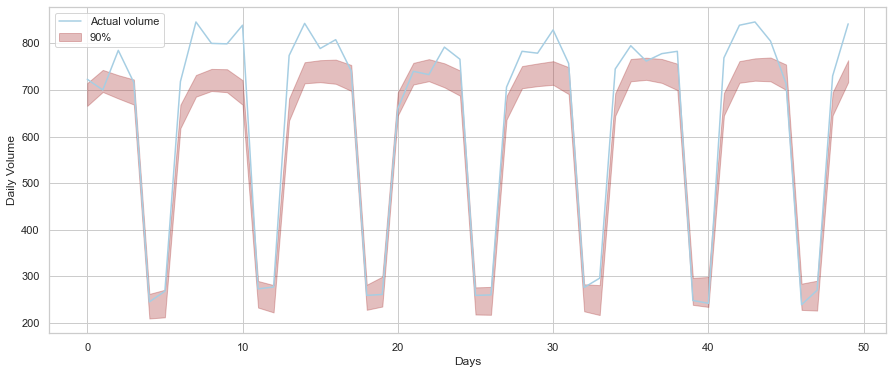

In [122]:
days = 50

fig, ax = plt.subplots(figsize = (15,6))

ax.plot(actual.reshape(-1)[:days], label = 'Actual volume')
ax.fill_between(range(days), pred_upper[:days], pred_lower[:days], label='90%', color='brown', alpha=.3)
ax.set(ylabel = "Daily Volume", xlabel="Days")
ax.legend();